In [1]:
import os, sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm
from time import time
from scipy.ndimage import gaussian_filter1d, median_filter
from skimage.morphology import binary_opening, binary_closing, binary_opening

sys.path.append("..")

In [2]:
import utils2p
import utils2p.synchronization
from utils2p.synchronization import get_lines_from_h5_file, process_cam_line, process_stimulus_line, crop_lines, get_times, SyncMetadata

In [3]:
from longterm import load, utils

In [193]:
fly_dir = os.path.join(load.NAS2_DIR_JB, "210727_PR_olfac_test", "Fly3")
trial_name = "001_ACV10P_B_40ML"
trial_dir = os.path.join(fly_dir, trial_name)
trial_image_dir = os.path.join(trial_dir, "behData", "images")
fictrac_data_file = glob.glob(os.path.join(trial_image_dir, "camera*.dat"))[0]
fictrac_data_file

'/mnt/NAS2/JB/210727_PR_olfac_test/Fly3/001_ACV10P_B_40ML/behData/images/camera_3-20210728_190948.dat'

In [5]:
sync_file = utils2p.find_sync_file(trial_dir)
sync_metadata_file = utils2p.find_sync_metadata_file(trial_dir)
seven_camera_metadata_file = utils2p.find_seven_camera_metadata_file(trial_dir)

In [6]:
def process_lines(sync_file, sync_metadata_file, seven_camera_metadata_file=None):
    """
    This function extracts all the standard lines and processes them.
    It works for both microscopes.
    Parameters
    ----------
    sync_file : str
        Path to the synchronization file.
    sync_metadata_file : str
        Path to the synchronization metadata file.
    metadata_2p_file : str
        Path to the ThorImage metadata file.
    seven_camera_metadata_file : str
        Path to the metadata file of the 7 camera system.
    Returns
    -------
    processed_lines : dictionary
        Dictionary with all processed lines.
    
    Examples
    --------
    >>> import utils2p
    >>> import utils2p.synchronization
    >>> experiment_dir = "data/mouse_kidney_raw/"
    >>> sync_file = utils2p.find_sync_file(experiment_dir)
    >>> metadata_file = utils2p.find_metadata_file(experiment_dir)
    >>> sync_metadata_file = utils2p.find_sync_metadata_file(experiment_dir)
    >>> seven_camera_metadata_file = utils2p.find_seven_camera_metadata_file(experiment_dir)
    >>> processed_lines = utils2p.synchronization.processed_lines(sync_file, sync_metadata_file, metadata_file, seven_camera_metadata_file)
    """
    processed_lines = {}
    try:
        processed_lines["odor"], processed_lines["pid"], processed_lines["Cameras"] = get_lines_from_h5_file(sync_file, ["odor", "pid", "Cameras",])
        processed_lines["Cameras"] = process_cam_line(processed_lines["Cameras"], seven_camera_metadata_file)
    except:
        processed_lines["odor"], processed_lines["Cameras"] = get_lines_from_h5_file(sync_file, ["odor", "Cameras",])
    
    # Get times of ThorSync ticks
    metadata = SyncMetadata(sync_metadata_file)
    freq = metadata.get_freq()
    times = get_times(len(processed_lines["odor"]), freq)
    processed_lines["Times"] = times

    return processed_lines

In [7]:
processed_lines = process_lines(sync_file, sync_metadata_file, seven_camera_metadata_file)

In [8]:
processed_lines_crop = {}
for k in processed_lines.keys():
    processed_lines_crop[k] = processed_lines[k][processed_lines["Cameras"]>=0]

In [76]:
conditions = ["None", "Odor1", "Odor2", "Odor3", "Odor4", "Odor5", "Odor6",
                    "Odor1R", "Odor2R",   # 7,8
                    "Odor1L", "Odor2L",   # 9,10
                    "Odor1B", "Odor2B", "WaterB"]   # 11,12,13

In [ ]:
t = processed_lines_crop["Times"]
t = t - t[0]
cam = processed_lines_crop["Cameras"]
odor = gaussian_filter1d(processed_lines_crop["odor"], sigma=100)

In [122]:
t_cam = np.hstack((0, t[np.where(np.diff(cam))[0]]))

In [69]:
min_pwm = 0  # np.quantile(processed_lines_crop["odor"], 0.001)
max_pwm = np.quantile(processed_lines_crop["odor"], 0.99)

In [81]:
odor_steps = 14
odor_quant = (np.round((odor-min_pwm) / (max_pwm-min_pwm) * odor_steps)).astype(int)


In [101]:
f_s_sync = 1 / np.mean(np.diff(t))
f_s_cam = np.mean(np.diff(cam)) / np.mean(np.diff(t))

In [103]:
f_s_sync

30000.0

In [104]:
odor_thres = processed_lines_crop["odor"] > 1
rep_time = 30
stim_time = 10

i = 0
list_i_start = []
while i < len(odor_thres)-1:
    i += 1
    if odor_thres[i]:
        list_i_start.append(i)
        i += int(f_s_sync * np.mean([rep_time, stim_time]))
        

In [107]:
list_t_start = t[list_i_start]
list_i_cam_start = cam[list_i_start]

list_i_end = [start + int(f_s_sync)*stim_time for start in list_i_start]
list_t_end = list_t_start + stim_time
list_i_cam_end = list_i_cam_start + int(f_s_cam)*stim_time


list_cond = [odor_quant[int(np.mean([start, end]))] for start, end in zip(list_i_start, list_i_end)]
list_cond_names = [conditions[cond] for cond in list_cond]

In [109]:
list_cond_names

['Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB',
 'Odor1B',
 'WaterB']

In [147]:
np.unique(list_cond_names)

array(['Odor1B', 'WaterB'], dtype='<U6')

In [143]:
condition_signals = []
for c in np.unique(list_cond_names):
    tmp = np.zeros_like(t_cam).astype(bool)
    for cond, i_start, i_end in zip(list_cond_names, list_i_cam_start, list_i_cam_end):
        if cond == c:
            tmp[i_start:i_end] = True
    condition_signals.append(tmp)

<IPython.core.display.Javascript object>


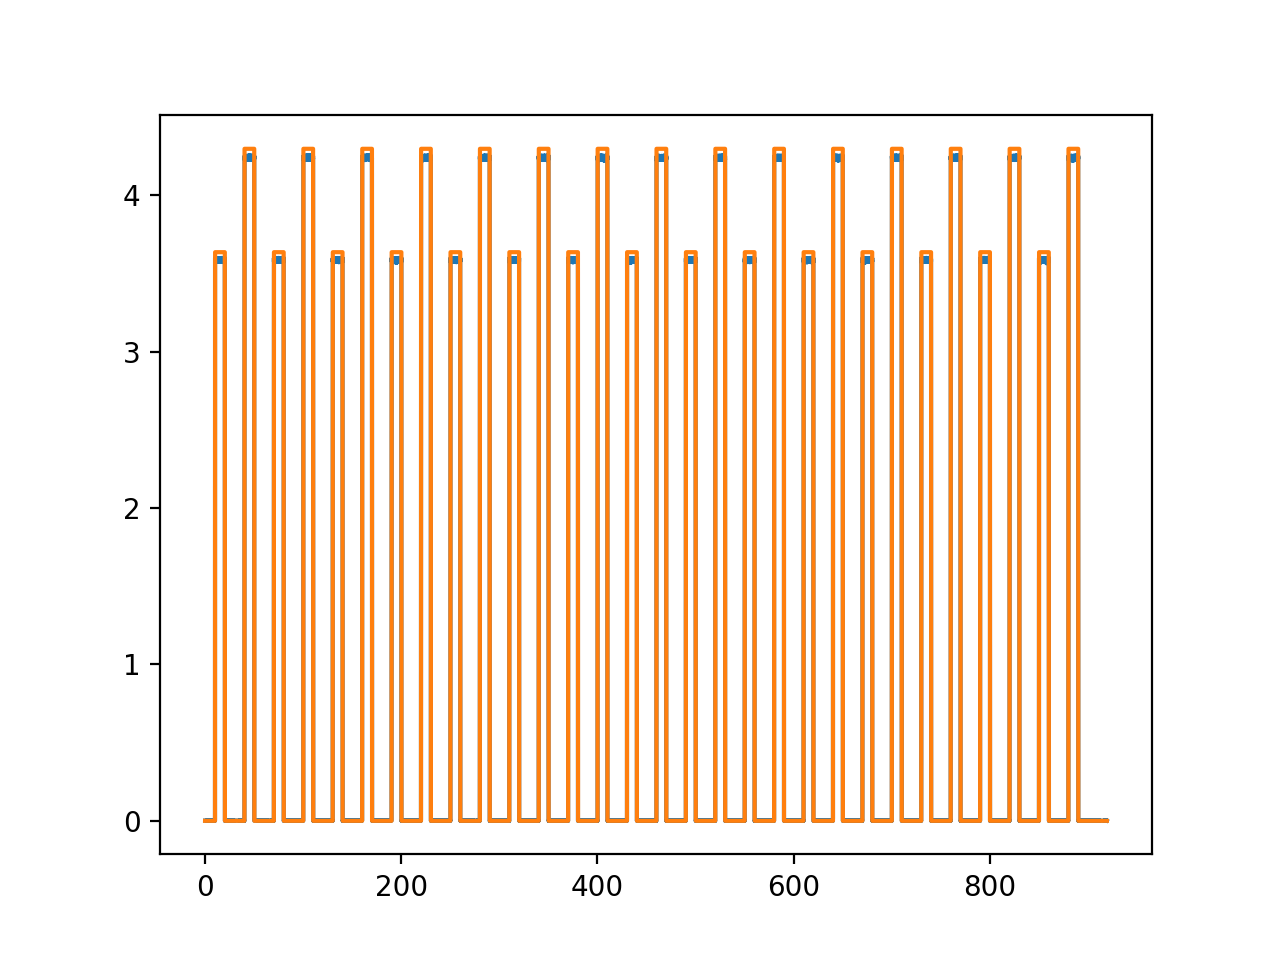

In [85]:
%matplotlib notebook
# plt.plot(t, processed_lines_crop["odor"])
plt.plot(t, odor)
plt.plot(t, odor_quant / odor_steps * (max_pwm-min_pwm) + min_pwm)




# loading fictrac data

In [110]:
col_names = np.arange(25) + 1

In [111]:
df = pd.read_csv(fictrac_data_file, header=None, names=col_names)
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.141593,0.000000,0.000000,0.000000,1.627492e+12,0,0.000000e+00,6.898895e+07
1,1,-0.001000,0.000001,-0.000002,4269.213261,-0.000002,0.001000,0.000001,-0.001000,0.000001,...,0.000002,6.283184,0.001591,0.001000,0.001000,0.000002,1.000000e+01,1,-1.627492e+12,6.898898e+07
2,2,0.000201,0.000046,-0.000115,4168.924406,0.000116,-0.000200,0.000045,-0.000799,0.000048,...,-0.000115,6.283139,3.668297,0.000232,0.000800,-0.000115,2.000000e+01,2,1.000000e+01,6.898901e+07
3,3,-0.000307,0.000016,0.000109,4060.798006,-0.000110,0.000307,0.000018,-0.001107,0.000064,...,-0.000005,6.283122,0.342959,0.000326,0.001107,-0.000005,3.000000e+01,3,1.000000e+01,6.898908e+07
4,4,-0.000268,0.000019,0.000088,3992.216747,-0.000088,0.000267,0.000020,-0.001375,0.000082,...,0.000083,6.283102,0.318726,0.000282,0.001374,0.000083,4.000000e+01,4,1.000000e+01,6.898916e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91995,91995,0.000365,-0.000140,-0.001472,5197.982078,0.001471,-0.000360,-0.000159,-0.555673,1.260510,...,-7.175430,3.089835,4.472580,0.001514,104.046103,-16.861954,9.199500e+05,91995,1.000000e+01,7.996267e+07
91996,91996,0.000003,-0.000190,0.001142,5160.416143,-0.001144,-0.000007,-0.000175,-0.556180,1.259872,...,-7.176573,3.090009,1.577122,0.001144,104.046096,-16.860809,9.199600e+05,91996,1.000000e+01,7.996279e+07
91997,91997,-0.000540,0.000305,0.001349,5170.215952,-0.001346,0.000536,0.000323,-0.557543,1.259232,...,-7.177890,3.089686,1.192213,0.001449,104.046632,-16.859463,9.199700e+05,91997,1.000000e+01,7.996290e+07
91998,91998,0.000028,0.000310,0.000566,5146.533080,-0.000562,-0.000030,0.000318,-0.558065,1.259263,...,-7.178453,3.089368,1.623585,0.000563,104.046602,-16.858901,9.199800e+05,91998,1.000000e+01,7.996302e+07


In [191]:
v_raw = df[19]
th_raw = df[18]

r_ball = 5  # mm

v = gaussian_filter1d(median_filter(v_raw, size=5), sigma=10) * r_ball  # rad/s == mm/s on ball with 1mm radius
th = (gaussian_filter1d(median_filter(th_raw, size=5), sigma=10) - np.pi) / np.pi * 180

In [125]:
from longterm.plot import shade_walk_rest

In [131]:
np.sum(condition_signals[0])

0

<IPython.core.display.Javascript object>


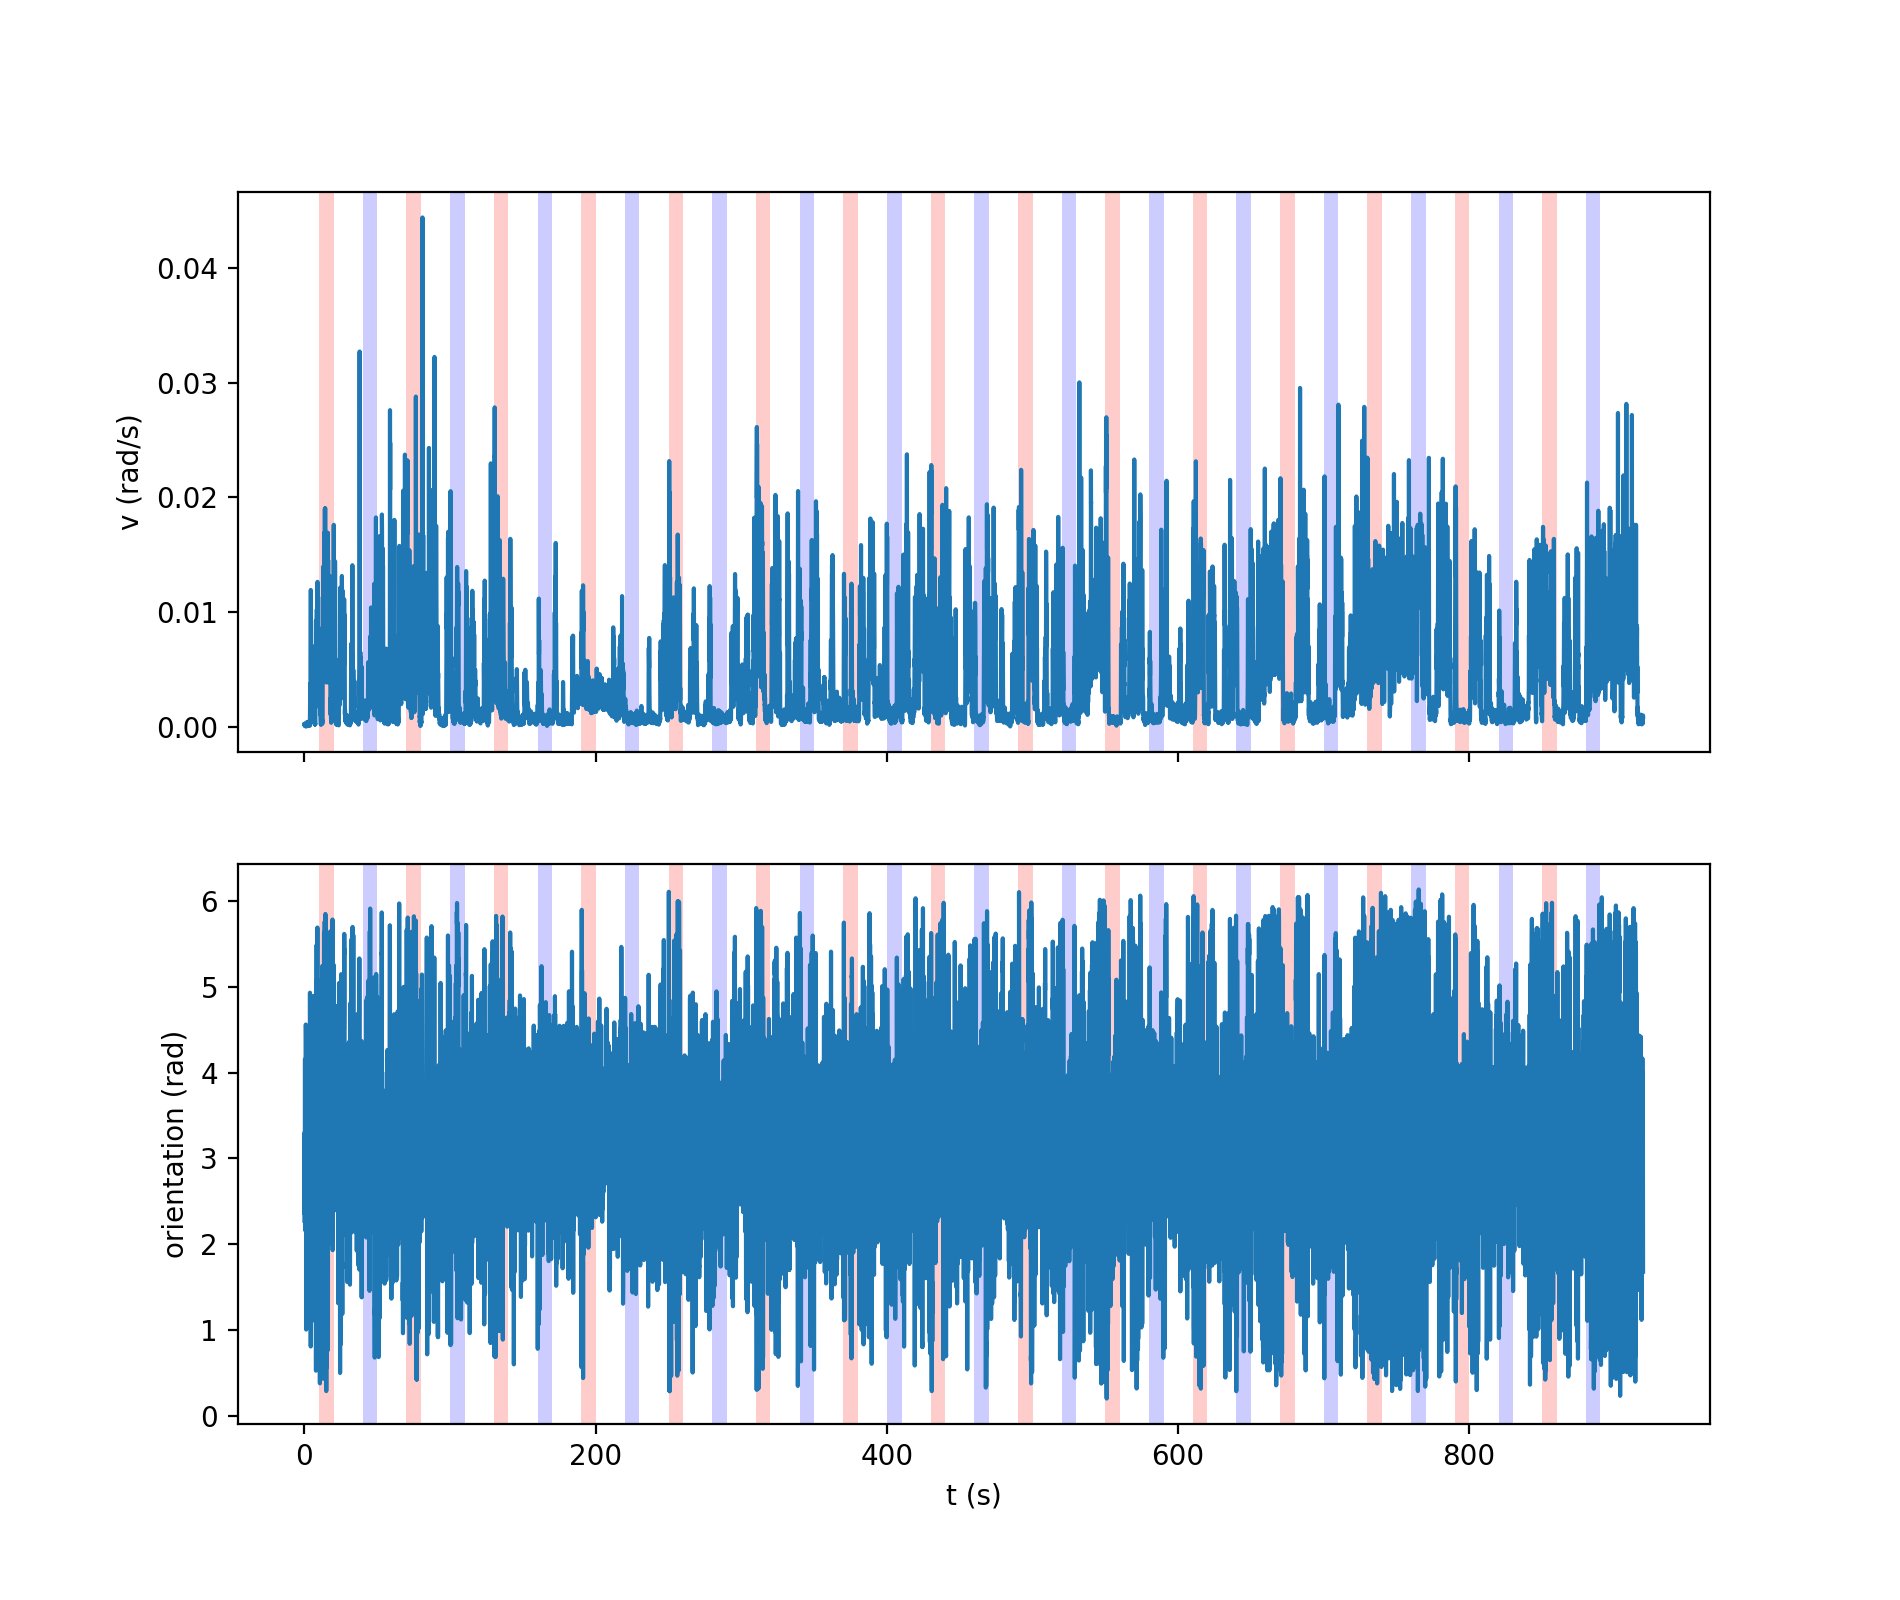

In [149]:
%matplotlib notebook
fig, axs = plt.subplots(2,1, figsize=(9.5, 8), sharex=True)
axs[0].plot(t_cam, v)
axs[0].set_ylabel("v (rad/s)")
shade_walk_rest(condition_signals[0], condition_signals[1], x=t_cam, ax=axs[0])

axs[1].plot(t_cam, th)
axs[1].set_ylabel("orientation (rad)")
axs[1].set_xlabel("t (s)")
shade_walk_rest(condition_signals[0], condition_signals[1], x=t_cam, ax=axs[1])

In [169]:
import longterm.plot as myplt
myplt = reload(myplt)

<IPython.core.display.Javascript object>


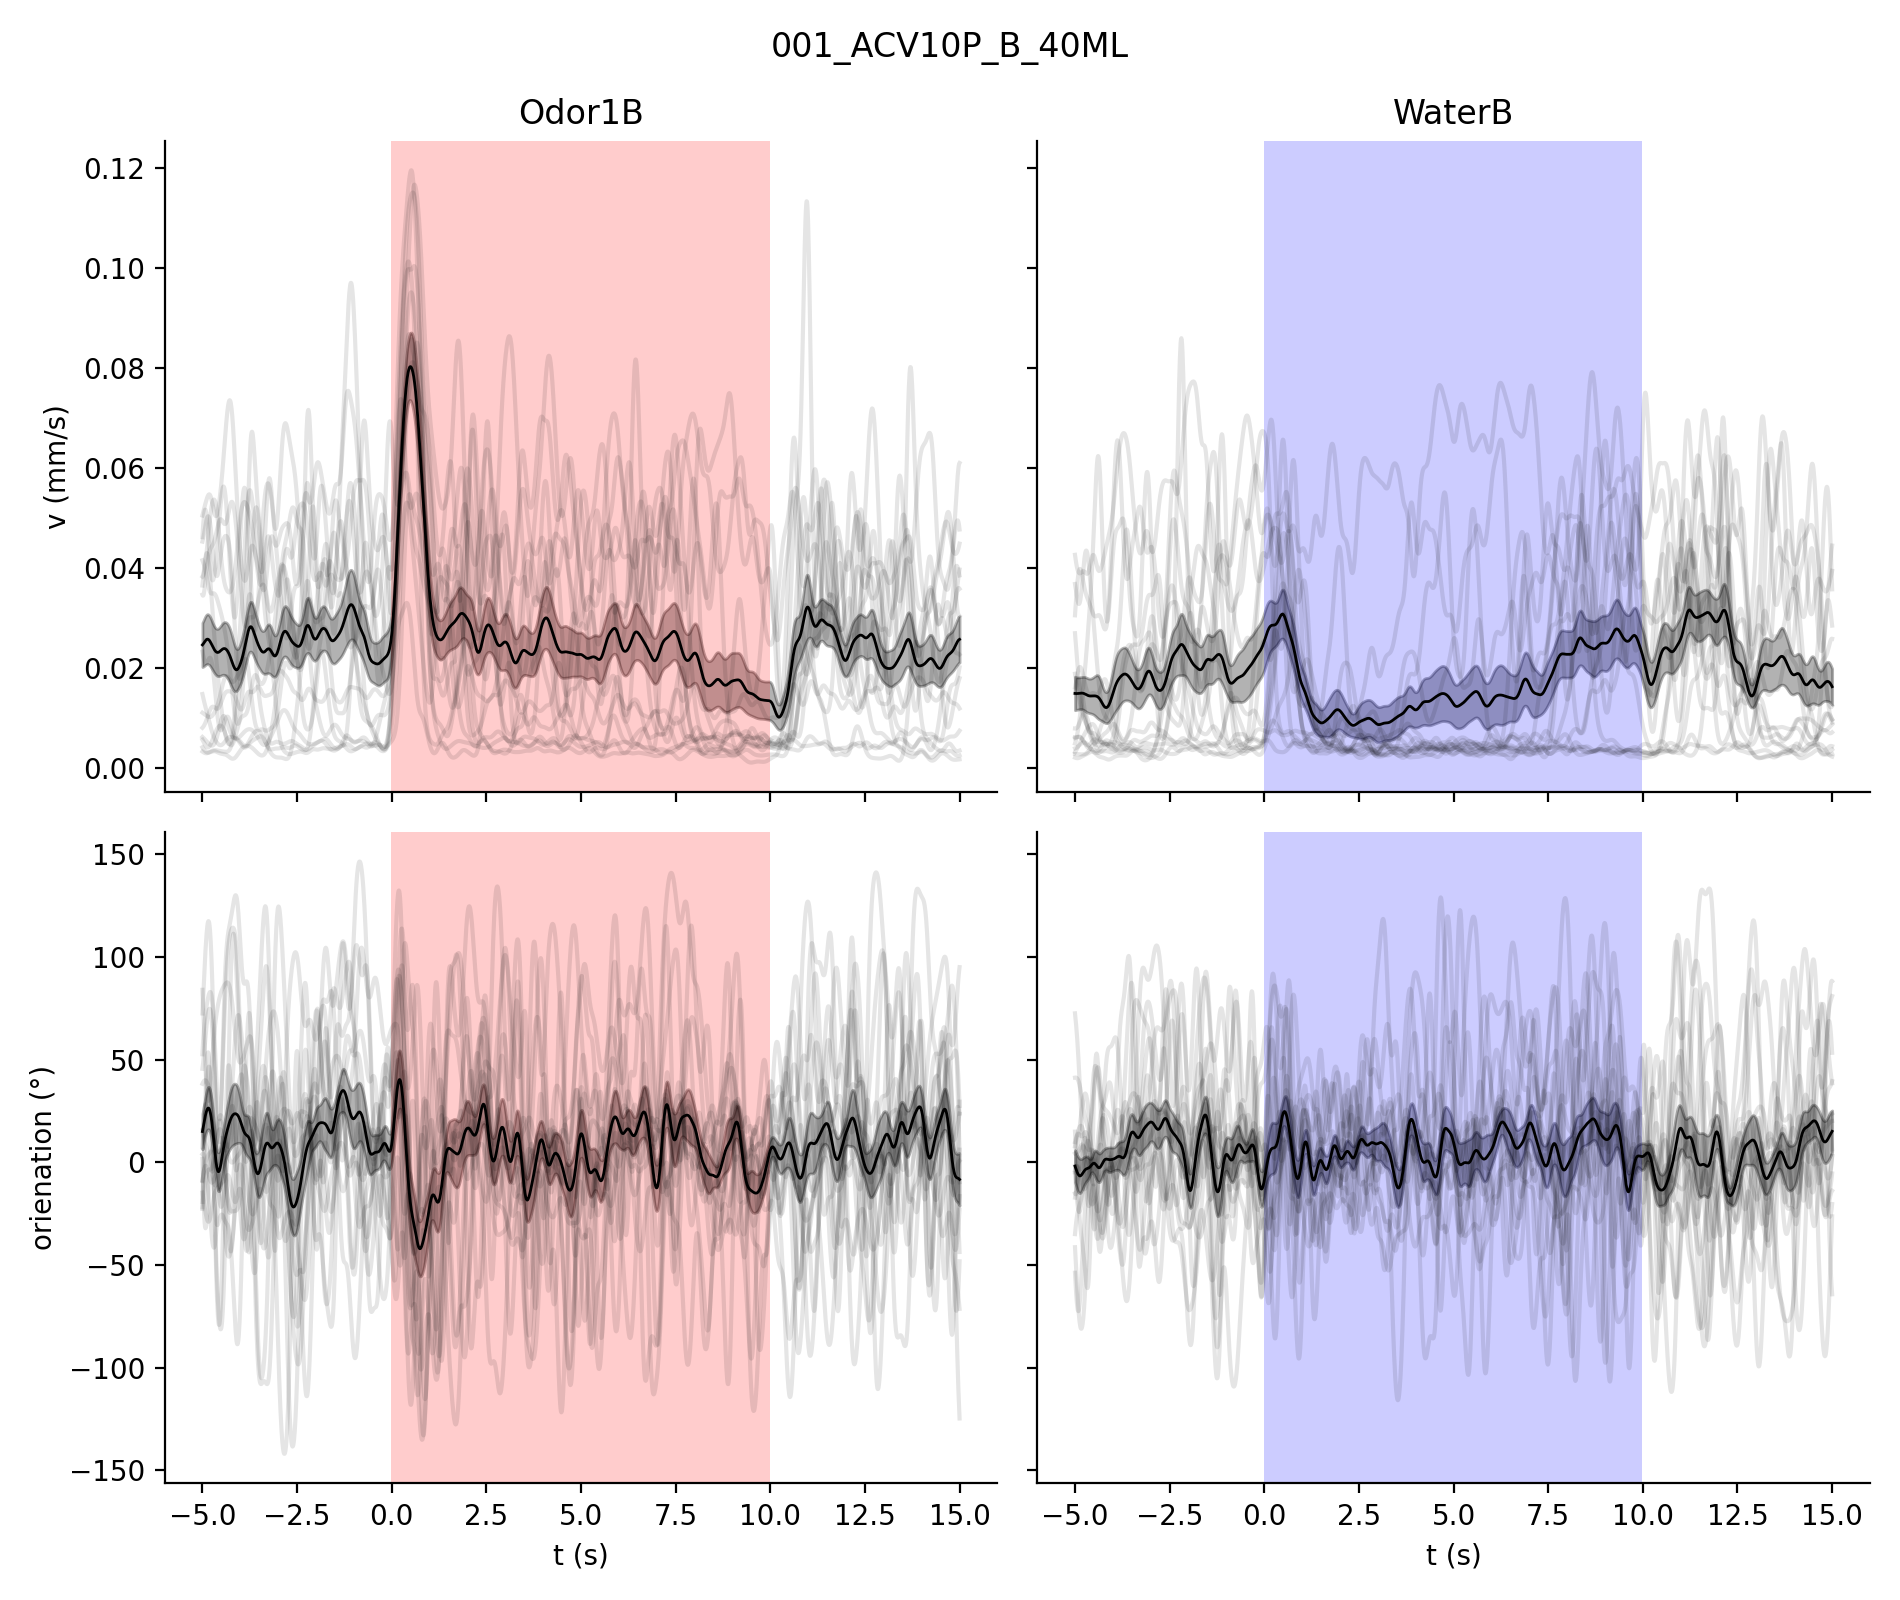

In [195]:
%matplotlib notebook
fig, axs = plt.subplots(2,2,figsize=(9.5, 8), sharex=True, sharey="row")


t_range = [-5,15]
i_range = [-500,1501]
t_short = np.arange(t_range[0], t_range[1]+1/int(f_s_cam), 1/int(f_s_cam))
cond_short = np.hstack((np.zeros((500)), np.ones((1000)),np.zeros((501))))


v_to_avg = []
th_to_avg = []
for i_c, c in enumerate(np.unique(list_cond_names)):
    if i_c == 0:
        myplt.shade_walk_rest(cond_short, np.zeros_like(cond_short), x=t_short, ax=axs[0,i_c])
        myplt.shade_walk_rest(cond_short, np.zeros_like(cond_short), x=t_short, ax=axs[1,i_c])
        axs[0,i_c].set_ylabel("v (mm/s)")
        axs[1,i_c].set_ylabel("orienation (°)")
    else:
        myplt.shade_walk_rest(np.zeros_like(cond_short), cond_short, x=t_short, ax=axs[0,i_c])
        myplt.shade_walk_rest(np.zeros_like(cond_short), cond_short, x=t_short, ax=axs[1,i_c])
    
    axs[1,i_c].set_xlabel("t (s)")    
    axs[0,i_c].set_title(c)
    # axs[1,i_c].set_title(c)
    
    v_to_avg.append([])
    th_to_avg.append([])
    for cond, i_start, i_end in zip(list_cond_names, list_i_cam_start, list_i_cam_end):
        if cond == c:
            v_tmp = v[i_start+i_range[0]:i_start+i_range[1]]
            th_tmp = th[i_start+i_range[0]:i_start+i_range[1]]
            v_to_avg[i_c].append(v_tmp)
            th_to_avg[i_c].append(th_tmp)
            axs[0, i_c].plot(t_short, v_tmp, "k", alpha=0.1)
            axs[1, i_c].plot(t_short, th_tmp, "k", alpha=0.1)
    myplt.plot_mu_sem(mu=np.mean(v_to_avg[i_c], axis=0), err=utils.sem(v_to_avg[i_c], axis=0), x=t_short, ax=axs[0,i_c], color="k")
    myplt.plot_mu_sem(mu=np.mean(th_to_avg[i_c], axis=0), err=utils.sem(th_to_avg[i_c], axis=0), x=t_short, ax=axs[1,i_c], color="k")
    
for ax in axs.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
fig.suptitle(trial_name)
fig.tight_layout()